In [1]:
import numpy as np
import pandas as pd
import json
import collections
from collections import defaultdict 
from functools import partial
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [2]:
multi_visit_mimic_dir = '/home/asem/GP/ehr-data/mimic4-multi-visit'

patients = pd.read_csv(f'{multi_visit_mimic_dir}/patients.csv.gz')
admissions = pd.read_csv(f'{multi_visit_mimic_dir}/admissions.csv.gz')
diagnoses_icd = pd.read_csv(f'{multi_visit_mimic_dir}/diagnoses_icd.csv.gz', dtype = {'icd_code': str})
procedures_icd = pd.read_csv(f'{multi_visit_mimic_dir}/procedures_icd.csv.gz', dtype = {'icd_code': str})

In [3]:
diagnoses_icd

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,15734973,20475282,3,2825,9
1,15734973,20475282,2,V0251,9
2,15734973,20475282,5,V270,9
3,15734973,20475282,1,64891,9
4,15734973,20475282,4,66481,9
...,...,...,...,...,...
4086853,13747041,25594844,6,R531,10
4086854,13747041,25594844,8,R0902,10
4086855,13747041,25594844,4,F1120,10
4086856,13747041,25594844,2,J189,10


In [4]:
admissions

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,10292548,26653546,2120-01-07 05:51:00,2120-01-12 13:45:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,ASIAN,NaN,NaN,0
1,19120008,24459786,2185-09-18 11:15:00,2185-09-20 15:30:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Medicare,?,MARRIED,ASIAN,NaN,NaN,0
2,11735820,24560424,2151-10-24 20:32:00,2151-10-25 12:25:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,?,MARRIED,HISPANIC/LATINO,2151-10-24 13:45:00,2151-10-25 12:25:00,0
3,16261811,26233676,2145-12-08 18:41:00,2145-12-09 19:40:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,SINGLE,WHITE,2145-12-08 14:44:00,2145-12-08 19:48:00,0
4,12988422,25192155,2132-05-24 07:10:00,2132-05-24 13:50:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,SINGLE,WHITE,2132-05-23 22:09:00,2132-05-24 13:50:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352655,18190942,20823019,2153-04-28 20:55:00,2153-05-01 15:09:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
352656,17892964,20786062,2180-09-17 00:00:00,2180-09-18 13:37:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Medicare,ENGLISH,SINGLE,WHITE,NaN,NaN,0
352657,17137572,20943099,2147-08-01 17:41:00,2147-08-02 17:30:00,NaN,EW EMER.,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,DIVORCED,HISPANIC/LATINO,2147-07-31 23:55:00,2147-08-01 19:37:00,0
352658,12298845,22347500,2138-05-31 00:00:00,2138-06-04 16:50:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0


In [5]:
admit = pd.to_datetime(admissions['admittime'], infer_datetime_format=True).dt.normalize() 
disch = pd.to_datetime(admissions['dischtime'], infer_datetime_format=True).dt.normalize()
admissions['days'] = (disch - admit).dt.days
admissions

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,days
0,10292548,26653546,2120-01-07 05:51:00,2120-01-12 13:45:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,ASIAN,NaN,NaN,0,5
1,19120008,24459786,2185-09-18 11:15:00,2185-09-20 15:30:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Medicare,?,MARRIED,ASIAN,NaN,NaN,0,2
2,11735820,24560424,2151-10-24 20:32:00,2151-10-25 12:25:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,?,MARRIED,HISPANIC/LATINO,2151-10-24 13:45:00,2151-10-25 12:25:00,0,1
3,16261811,26233676,2145-12-08 18:41:00,2145-12-09 19:40:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,SINGLE,WHITE,2145-12-08 14:44:00,2145-12-08 19:48:00,0,1
4,12988422,25192155,2132-05-24 07:10:00,2132-05-24 13:50:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,SINGLE,WHITE,2132-05-23 22:09:00,2132-05-24 13:50:00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352655,18190942,20823019,2153-04-28 20:55:00,2153-05-01 15:09:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0,3
352656,17892964,20786062,2180-09-17 00:00:00,2180-09-18 13:37:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Medicare,ENGLISH,SINGLE,WHITE,NaN,NaN,0,1
352657,17137572,20943099,2147-08-01 17:41:00,2147-08-02 17:30:00,NaN,EW EMER.,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,DIVORCED,HISPANIC/LATINO,2147-07-31 23:55:00,2147-08-01 19:37:00,0,1
352658,12298845,22347500,2138-05-31 00:00:00,2138-06-04 16:50:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0,4


In [6]:
longest_admission = {}
for subject_id, subject_df in admissions.groupby('subject_id'):
    longest_admission[subject_id] = subject_df.days.max()
    
admissions['max_days'] = admissions.subject_id.map(longest_admission)
subjects = list(set(admissions.subject_id))
longest_admission_df = pd.DataFrame({'subject_id': subjects,
                                    'longest_admission': map(longest_admission.get, subjects)})

<AxesSubplot:xlabel='days', ylabel='Count'>

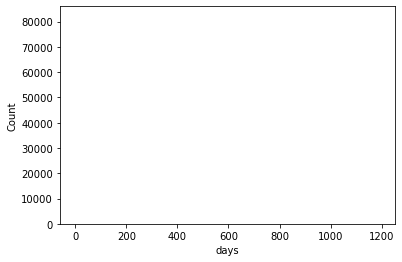

In [7]:
sns.histplot(data=admissions, x="days")

array([[<AxesSubplot:title={'center':'days'}>]], dtype=object)

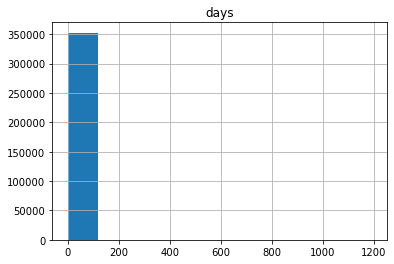

In [8]:
admissions.hist('days')

In [9]:
np.mean(admissions.max_days <= 14)

0.7532382464696875

<AxesSubplot:xlabel='longest_admission', ylabel='Count'>

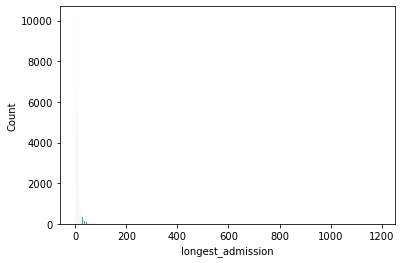

In [10]:
sns.histplot(data=longest_admission_df, x="longest_admission")

In [11]:
np.mean(longest_admission_df.longest_admission <= 14)

0.8464649525629968

In [12]:
len(subjects)

85798

In [13]:
np.mean(longest_admission_df.longest_admission <= 14) * len(subjects)

72625.0

In [14]:
subjects_2wks = set(longest_admission_df[longest_admission_df.longest_admission <= 14].subject_id)

In [15]:
len(subjects_2wks)

72625

In [16]:
patients_2wks = patients[patients.subject_id.isin(subjects_2wks)].reset_index(drop=True)
admissions_2wks = admissions[admissions.subject_id.isin(subjects_2wks)].reset_index(drop=True)
diagnoses_icd_2wks = diagnoses_icd[diagnoses_icd.hadm_id.isin(admissions_2wks.hadm_id)].reset_index(drop=True)
procedures_icd_2wks = procedures_icd[procedures_icd.hadm_id.isin(admissions_2wks.hadm_id)].reset_index(drop=True)

In [17]:
print('#admissions per patient', len(admissions_2wks) / len(patients_2wks))
print('days between admissions')
admissions_2wks['days'].describe()

#admissions per patient 3.6576523235800344
days between admissions


count    265637.000000
mean          3.213159
std           2.878057
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          14.000000
Name: days, dtype: float64

In [18]:
patients_2wks.to_csv(f'{multi_visit_mimic_dir}/patients_2wks.csv.gz', compression='gzip', index=False)
admissions_2wks.to_csv(f'{multi_visit_mimic_dir}/admissions_2wks.csv.gz', compression='gzip', index=False)
diagnoses_icd_2wks.to_csv(f'{multi_visit_mimic_dir}/diagnoses_icd_2wks.csv.gz', compression='gzip', index=False)
procedures_icd_2wks.to_csv(f'{multi_visit_mimic_dir}/procedures_icd_2wks.csv.gz', compression='gzip', index=False)